In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import loompy as lp
import pandas as pd
import anndata as ad
import seaborn as sns
import re
import json
import decoupler as dc
import scipy.stats as stats
import matplotlib.pyplot as plt

Read in data from 10X Cell Ranger Output From GSE224714

In [2]:
TNC_ad = sc.read_10x_mtx("Data/TNC")

Incorporate the given metadata with the counts

In [3]:
import gzip

with gzip.open('Data/GSE224714_TNC_meta.txt.gz', 'rt') as f:
    TNC_meta = pd.read_csv(f, delimiter='\t')

In [4]:
# Ensure both barcode columns are of the same type (string)
TNC_ad.obs.index = TNC_ad.obs.index.astype(str)
TNC_meta['Barcode'] = TNC_meta['Barcode'].astype(str)

# Merge the metadata with the AnnData object
TNC_ad.obs = TNC_ad.obs.merge(TNC_meta, left_index=True, right_on='Barcode')

# Check the updated AnnData object
print(TNC_ad.obs.head())

                     Barcode Demuxlet CellType_major CellType_minor Time  \
0  P4_d1_BM_AAACCTGCATATGGTC      NaN      MatureNeu     MatureNeu2   d1   
1  P4_d1_BM_AAACCTGGTGTGGCTC      NaN       Monocyte       Monocyte   d1   
2  P4_d1_BM_AAACCTGTCGGAAACG      NaN       Monocyte       Monocyte   d1   
3  P4_d1_BM_AAACCTGTCGTCCAGG      NaN       Monocyte       Monocyte   d1   
4  P4_d1_BM_AAACGGGAGGAGTTGC      NaN       Monocyte       Monocyte   d1   

  Patient Tissue  
0      P1     BM  
1      P1     BM  
2      P1     BM  
3      P1     BM  
4      P1     BM  


/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/functools.py:907: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [5]:
# Include a patient_time column for data harmonization later
TNC_ad.obs["Patient_Time"] = TNC_ad.obs["Patient"].astype(str) + "_" + TNC_ad.obs["Time"].astype(str)


It seems like they already have filtered out doublets and low quality cells so I'm moving on.

In [6]:
TNC_ad.layers['counts'] = TNC_ad.X.copy()
sc.pp.normalize_total(TNC_ad, target_sum = 10000)
sc.pp.log1p(TNC_ad)
TNC_ad.layers['log_counts'] = TNC_ad.X.copy()
sc.pp.highly_variable_genes(TNC_ad)
sc.pp.scale(TNC_ad, max_value=10)
sc.pp.pca(TNC_ad, mask_var="highly_variable", svd_solver='arpack', random_state=0)
#sc.pl.pca_variance_ratio(TNC_ad, log=True, n_pcs=50, save='') # shows that 30 is a good amount to keep

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/functools.py:907: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Harmony based integration for the data due to donor differences

In [7]:
sce.pp.harmony_integrate(TNC_ad, 'Patient', random_state=0)

2026-02-03 21:04:49,837 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-03 21:05:16,394 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-03 21:05:17,602 - harmonypy - INFO - Iteration 1 of 10
2026-02-03 21:07:26,201 - harmonypy - INFO - Iteration 2 of 10
2026-02-03 21:09:31,173 - harmonypy - INFO - Iteration 3 of 10
2026-02-03 21:11:27,376 - harmonypy - INFO - Converged after 3 iterations


In [8]:
sc.pp.neighbors(TNC_ad, n_pcs=30, random_state=0, use_rep='X_pca_harmony')
sc.tl.umap(TNC_ad, random_state=0)
for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
    sc.tl.leiden(TNC_ad, 
                  resolution=res, 
                  key_added=f'leiden_res_{res}', 
                  flavor='igraph',
                  random_state=0)

In [9]:
TNC_ad.obsm['X_umap'][:, 0] *= -1

Finding the NK cells in TNC_ad and making a new anndata object that is subsetted just on those cells

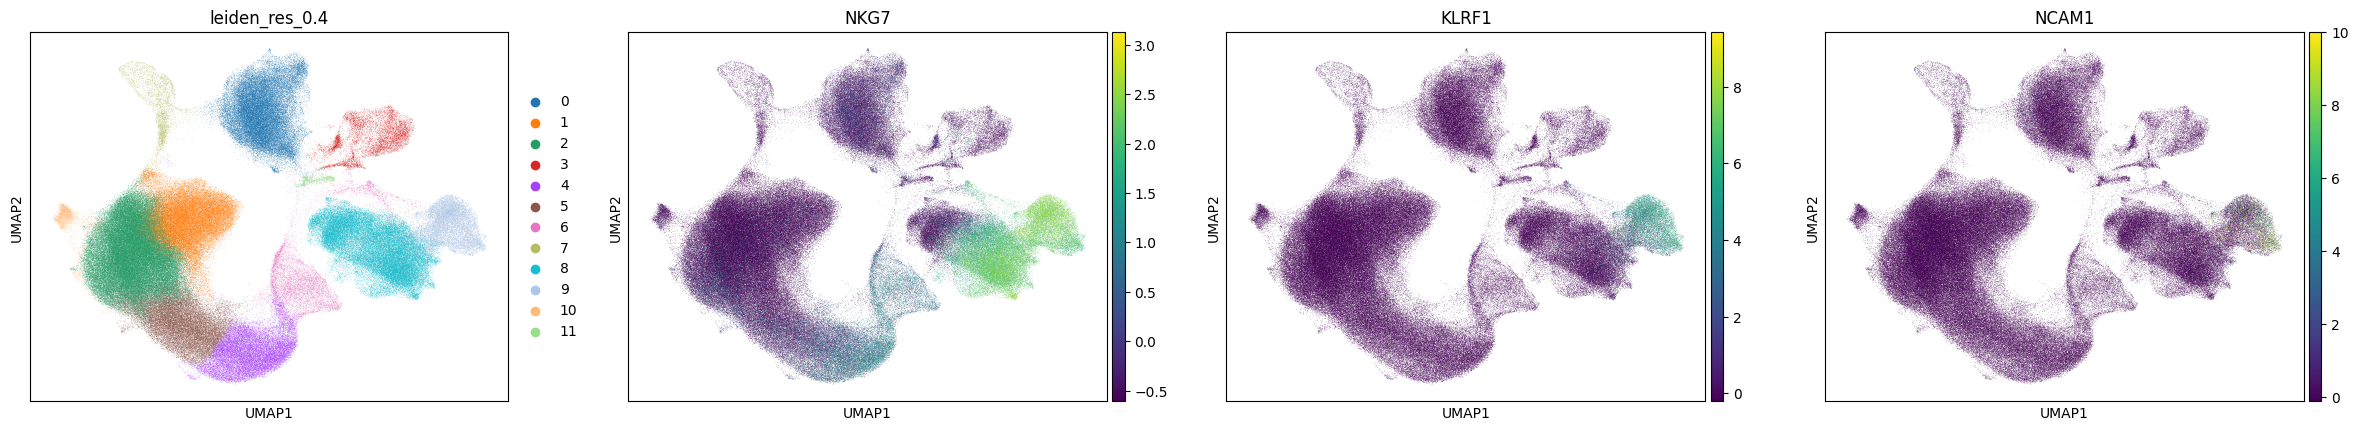

In [10]:
sc.pl.umap(TNC_ad, color=['leiden_res_0.4', 'NKG7', 'KLRF1', 'NCAM1'], ncols=4) 

In [11]:
# After looking for "NKG7", "KLRF1", and "NCAM1",
# I found the NK cells in leiden clustering "leiden_res_0.4" in cluster number 9
NK_ad = TNC_ad[TNC_ad.obs['leiden_res_0.4'] == '9', :].copy()
NK_ad.X = NK_ad.layers['log_counts'].copy()
sc.pp.highly_variable_genes(NK_ad)
sc.pp.scale(NK_ad, max_value=10)
sc.pp.pca(NK_ad, mask_var="highly_variable", random_state=0)
#sc.pl.pca_variance_ratio(NK_ad, log=True) # Chose 20 for this dataset
sce.pp.harmony_integrate(NK_ad, key=['Patient'], random_state=0)
sc.pp.neighbors(NK_ad, n_pcs=20, use_rep='X_pca_harmony', random_state=0)
sc.tl.umap(NK_ad, random_state=0)
for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
    sc.tl.leiden(NK_ad, 
                  resolution=res, 
                  key_added=f'leiden_res_{res}', 
                  flavor='igraph',
                  random_state=0)

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/functools.py:907: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2026-02-03 21:17:42,925 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-03 21:17:46,971 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-03 21:17:47,107 - harmonypy - INFO - Iteration 1 of 10
2026-02-03 21:17:51,991 - harmonypy - INFO - Iteration 2 of 10
2026-02-03 21:17:56,035 - harmonypy - INFO - Converged after 2 iterations


In [1]:
#Reorder time points how they show up on the plots
# 1. Define the exact order you want (chronological)
new_order_TNC = ['Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd70', 'd90', '>d180']
new_order_NK = ['Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180']

# 2. Update TNC_ad
# Ensure it's categorical first, then apply the new order
TNC_ad.obs['Time'] = TNC_ad.obs['Time'].astype('category')
TNC_ad.obs['Time'] = TNC_ad.obs['Time'].cat.reorder_categories(new_order_TNC)

# 3. Update NK_ad
NK_ad.obs['Time'] = NK_ad.obs['Time'].astype('category')
NK_ad.obs['Time'] = NK_ad.obs['Time'].cat.reorder_categories(new_order_NK)

Saving the anndata objects

In [13]:
TNC_ad.write('HSCT_anndata.h5ad', compression='lzf')
NK_ad.write('NK_anndata.h5ad', compression='lzf')

Run pyscenic on the transplant NK cells

In [2]:
NK_ad = sc.read_h5ad('NK_anndata.h5ad')

In [3]:
# Use the raw counts matrix
# Note: SCENIC expects (genes x cells), so .transpose() is correct.
raw_counts_matrix = NK_ad.layers['counts'].transpose()

# --- Create Row (Gene) Attributes ---
adata_row_attrs = {
    'Gene': np.array(NK_ad.var_names)
}

# --- Create Column (Cell) Attributes ---
# IMPORTANT: Calculate nGene and nUMI from the raw matrix
adata_col_attrs = {
    'CellID': np.array(NK_ad.obs_names),
    'nGene': np.array(np.sum(raw_counts_matrix > 0, axis=0)).flatten(),
    'nUMI': np.array(np.sum(raw_counts_matrix, axis=0)).flatten()
}

# --- Create the loom file ---
# Now, we pass the raw_counts_matrix to the function
lp.create('pyscenic/NK_HSCT.loom', raw_counts_matrix, adata_row_attrs, adata_col_attrs)

In [4]:
%%writefile pyscenic/NK_HSCT_pyscenic_job.sh
#!/bin/bash
#SBATCH --account=PAS2527
#SBATCH --time=2:00:00
#SBATCH --mail-type=ALL
#SBATCH --ntasks-per-node=80
#SBATCH --partition=nextgen
#SBATCH --output=NK_HSCT_pyscenic.slurm-%j.out
#SBATCH --error=NK_HSCT_pyscenic.slurm-%j.err

# Exit on error
set -e

# Load modules and activate conda environment with pyscenic
module load miniconda3/24.1.2-py310
source activate pyscenic

# ==============================================================================
# CONFIGURATION
# ==============================================================================
# Define the source directory to make the script cleaner
SRC_DIR="$HOME/Single_Cell_Files/Huo_et_al_Transplant_Dataset/Python_Analysis/pyscenic/"
DB_DIR="$HOME/Single_Cell_Files/03012023_CITESeq/scanpy_muon/pyscenic/pySCENIC_files"

# Copy Static Database Files to $TMPDIR (Do this once)
echo "Copying reference databases to $TMPDIR..."
rsync -av $DB_DIR/allTFs_hg38.txt $TMPDIR/
rsync -av $DB_DIR/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl $TMPDIR/
rsync -av $DB_DIR/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather $TMPDIR/
rsync -av $DB_DIR/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather $TMPDIR/

# Move to scratch
cd $TMPDIR

# ==============================================================================
# FUNCTION: Run Pipeline for a specific Sample
# ==============================================================================
run_pyscenic() {
    SAMPLE_ID=$1
    echo "----------------------------------------------------------------"
    echo "STARTING PIPELINE FOR: $SAMPLE_ID"
    echo "----------------------------------------------------------------"

    # 1. Copy specific loom file to TMP
    echo "Copying $SAMPLE_ID.loom..."
    rsync -av $SRC_DIR/$SAMPLE_ID.loom $TMPDIR/

    # 2. GRN Step
    echo "Running GRN for $SAMPLE_ID..."
    pyscenic grn \
        -o ${SAMPLE_ID}_adj.csv \
        ${SAMPLE_ID}.loom allTFs_hg38.txt \
        --num_workers 80 \
        --seed 123

    # 3. CTX Step
    # Note: Outputting as .csv (standard), assumed previously .yml in your script
    echo "Running CTX for $SAMPLE_ID..."
    pyscenic ctx \
        -o ${SAMPLE_ID}_reg.csv \
        --expression_mtx_fname ${SAMPLE_ID}.loom \
        --annotations_fname motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
        ${SAMPLE_ID}_adj.csv \
        hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
        hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
        --num_workers 40 \
        --mode custom_multiprocessing \
        --mask_dropouts

    # 4. AUCell Step
    echo "Running AUCell for $SAMPLE_ID..."
    pyscenic aucell \
        -o ${SAMPLE_ID}_pyscenic_results.loom \
        ${SAMPLE_ID}.loom ${SAMPLE_ID}_reg.csv \
        --num_workers 40 \
        --seed 123

    # 5. Copy Results Back
    echo "Copying results for $SAMPLE_ID to a results folder"
    OUT_FOLDER="$SRC_DIR/${SAMPLE_ID}_results"
    mkdir -p $OUT_FOLDER
    rsync -av ${SAMPLE_ID}_adj.csv $OUT_FOLDER
    rsync -av ${SAMPLE_ID}_reg.csv $OUT_FOLDER
    rsync -av ${SAMPLE_ID}_pyscenic_results.loom $OUT_FOLDER
    
    # Clean up loom from TMP to save space for next run
    rm ${SAMPLE_ID}.loom
    rm ${SAMPLE_ID}_adj.csv
    rm ${SAMPLE_ID}_reg.csv
    rm ${SAMPLE_ID}_pyscenic_results.loom
    
    echo "Completed $SAMPLE_ID"
}

# ==============================================================================
# EXECUTION
# ==============================================================================

# Run for NK_HSCT
run_pyscenic "NK_HSCT"

echo "All samples processed successfully!"

Writing pyscenic/NK_HSCT_pyscenic_job.sh


Loading pyscenic results back in

In [ ]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================
# Update this to wherever your "pyscenic" folder lives relative to this notebook
PYSCENIC_DIR = 'pyscenic' 

# ==============================================================================
# FUNCTION: Import PySCENIC Results
# ==============================================================================
def import_pyscenic_results(adata, sample_id):
    """
    Loads AUCell matrix from Loom, cleans columns, aligns to MuData, and saves to .obsm
    """
    # 1. Construct the path based on your Bash script's folder structure
    #    Path: pyscenic/D28_results/D28_pyscenic_results.loom
    loom_path = os.path.join(PYSCENIC_DIR, f"{sample_id}_results", f"{sample_id}_pyscenic_results.loom")
    
    if not os.path.exists(loom_path):
        print(f"❌ Error: File not found: {loom_path}")
        return

    print(f"Loading results for {sample_id} from: {loom_path}")
    
    # 2. Connect and load data
    with lp.connect(loom_path, mode='r', validate=False) as lf:
        auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)

    # 3. Clean the column names (RegEx)
    #    Turns "Regulon(SOX2(+))" -> "SOX2"
    new_columns = [re.sub(r"Regulon\((\w+)\(.*\)\)", r"\1", c) for c in auc_mtx.columns]
    auc_mtx.columns = new_columns

    # 4. Re-index to match the specific MuData object
    #    This ensures cells are in the exact same order as your mdata object
    #    and fills missing cells with NaN (though there shouldn't be any if indices match)
    auc_mtx = auc_mtx.reindex(adata.obs_names)

    # 5. Save to .obsm
    adata.obsm['Pyscenic_AUC'] = auc_mtx

    print(f"✅ Success! Added {auc_mtx.shape[1]} regulons to .obsm['Pyscenic_AUC']")
    print("-" * 40)

# ==============================================================================
# EXECUTION
# ==============================================================================

# Run for NK_ad
import_pyscenic_results(NK_ad, "NK_HSCT")

In [ ]:
NK_ad.write_h5ad('NK_anndata.h5ad', compression='lzf')

Complete this step only after finishing generating the necesssary files for Regulon Analysis in a slurm batch since it requires have the results from the regulon mapping.

In [ ]:
with lp.connect('pyscenic/CD34/CD34_results.loom', mode = 'r+', validate = False) as lf:
   auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
   regulons = load_signatures('pyscenic/CD34/CD34_reg.yml')
   add_scenic_metadata(CD34_ad, auc_mtx, regulons)

In [ ]:
#with lp.connect('TNC_SCT_results.loom', mode = 'r+', validate = False) as lf:
#    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
#    regulons = load_signatures('TNC_SCT_reg.yml')
#    add_scenic_metadata(TNC_ad, auc_mtx, regulons)

In [ ]:
# 1. Connect to the loom file and load the AUC matrix as a pandas DataFrame
with lp.connect('pyscenic/NK/New_Analysis/NK_pyscenic_results_v2.loom', mode='r', validate=False) as lf:
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)

# 2. Clean the column names (your "intuitive names" request)
# This regex finds "Regulon(GENE(+))" and extracts just "GENE"
new_columns = [re.sub(r"Regulon\((\w+)\(.*\)\)", r"\1", c) for c in auc_mtx.columns]
auc_mtx.columns = new_columns

# 3. Re-index the matrix to match your AnnData object's cell order
# This is a critical step for safety!
auc_mtx = auc_mtx.reindex(NK_ad.obs_names)

# 4. Assign the entire DataFrame to the .obsm slot
NK_ad.obsm['Pyscenic_AUC'] = auc_mtx

print("✅ AUC scores added to NK_ad.obsm['AUC']")
print("Example regulons:", auc_mtx.columns.to_list()[:5])

In [ ]:
# --- 1. Your code to generate the modules ---
# (This assumes 'tonsil_ad.h5ad' already contains the 
# results from sc.tl.rank_genes_groups)
try:
    adata = sc.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/pySCENIC_Analyses/tonsil_ad.h5ad')
    
    # Get DEGs for Stage 4b
    S4b_degs = sc.get.rank_genes_groups_df(adata, group=['Stage 4b'], log2fc_min=0, pval_cutoff=0.05)
    S4b_degs = S4b_degs[0:250]
    S4b_module = S4b_degs['names'].tolist()

    # Get DEGs for Stage 5
    S5_degs = sc.get.rank_genes_groups_df(adata, group=['Stage 5'], log2fc_min=0, pval_cutoff=0.05)
    S5_degs = S5_degs[0:250]
    S5_module = S5_degs['names'].tolist()

    print(f"Created module 'Stage_4b' with {len(S4b_module)} genes.")
    print(f"Created module 'Stage_5' with {len(S5_module)} genes.")

    # --- 2. Code to update your JSON file ---
    
    module_file = 'reb_li_gene_modules.json'

    # Load the existing modules
    with open(module_file, 'r') as f:
        gene_modules = json.load(f)

    print(f"Loaded {len(gene_modules)} existing modules from {module_file}")

    # Add your new modules to the dictionary
    gene_modules['Stage_4b'] = S4b_module
    gene_modules['Stage_5'] = S5_module

    # Save the updated dictionary back to the file
    with open(module_file, 'w') as f:
        json.dump(gene_modules, f, indent=4)

    print(f"✅ Successfully added new modules. '{module_file}' now contains {len(gene_modules)} modules.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("This can happen if 'tonsil_ad.h5ad' does not contain rank_genes_groups results.")

# 3. Iterate and apply sc.tl.score_genes for each module
# We will use the log-normalized data stored in .raw
for module_name, gene_list in gene_modules.items():
    print(f"Scoring module: {module_name}")
    
    # Use sc.tl.score_genes
    # We use use_raw=True to use the log-normalized data
    # The score will be saved in NK_ad.obs[module_name]
    sc.tl.score_genes(
        NK_ad,
        gene_list,
        score_name=module_name,
        use_raw=True,  # Assumes you stored log-counts in .raw as we discussed
        #ctrl_size=50   # Standard to use 50 control genes
    )

print("All module scores have been added to NK_ad.obs.")

In [40]:
#Code to reorganize axis for plotting time point data.
#NK_ad.obs['Time'] = NK_ad.obs['Time'].cat.reorder_categories( ['Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180'], ordered=True)
#CD34_ad.obs['Time'] = CD34_ad.obs['Time'].cat.reorder_categories( ['Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd90', 'd180+'], ordered=True)
TNC_ad.obs['Time'] = TNC_ad.obs['Time'].cat.reorder_categories( ['Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd70', 'd90', '>d180'], ordered=True)

In [ ]:
import scipy.stats as stats

# Define the groups for comparison
groups = NK_ad.obs['Time'].unique()

# Prepare a DataFrame to store the Wilcoxon results along with mean values
results = pd.DataFrame(columns=['Regulon', 'Group1', 'Group2', 'Group1_Mean', 'Group2_Mean', 'Statistic', 'p-value'])

# Perform Wilcoxon rank-sum test for each regulon
for regulon in NK_ad.obs.columns:
    if regulon.startswith('Regulon'):
        for i, group1 in enumerate(groups):
            for group2 in groups[i+1:]:
                data1 = NK_ad.obs.loc[NK_ad.obs['Time'] == group1, regulon]
                data2 = NK_ad.obs.loc[NK_ad.obs['Time'] == group2, regulon]
                stat, p = stats.ranksums(data1, data2)
                mean1 = data1.mean()
                mean2 = data2.mean()
                results = pd.concat([results, pd.DataFrame({
                    'Regulon': [regulon],
                    'Group1': [group1],
                    'Group2': [group2],
                    'Group1_Mean': [mean1],
                    'Group2_Mean': [mean2],
                    'Statistic': [stat],
                    'p-value': [p]
                })], ignore_index=True)

# # Filter results to keep only statistically significant ones
# significant_results = results[results['p-value'] < 0.05]                
                
# Save the results to a CSV file
results.to_csv('wilcoxon_regulons_with_means.csv', index=False)

# Display the results
print(results)


Reading in a gene set from www.gsea-msigdb.org from a tsv format and importing it into my environment to use to create a gene score that I can map onto a violin plot

This example is for a BIOCARTA_MTOR_PATHWAY gene set

In [ ]:
# Read the TSV file into a DataFrame
tsv_file = "GSEA_genesets/MTOR/BIOCARTA_MTOR_PATHWAY.v2024.1.Hs.tsv"
gene_df = pd.read_csv(tsv_file, sep='\t')

# Extract the "GENE_SYMBOLS" row
gene_symbols_row = gene_df.loc[gene_df["STANDARD_NAME"] == "GENE_SYMBOLS", "BIOCARTA_MTOR_PATHWAY"].values[0]

# Split the gene symbols into a list
gene_list = gene_symbols_row.split(',')

# Remove empty strings and duplicates
gene_list_cleaned = list(filter(None, gene_list))
gene_list_cleaned = list(set(gene_list_cleaned))

# Assuming your AnnData object is NK_ad
sc.tl.score_genes(NK_ad, gene_list=gene_list_cleaned, score_name="BC_MTOR_PATHWAY")

In [ ]:
# Read the TSV file into a DataFrame
tsv_file = "GSEA_genesets/MTOR/KEGG_MTOR_SIGNALING_PATHWAY.v2024.1.Hs.tsv"
gene_df = pd.read_csv(tsv_file, sep='\t')

# Extract the "GENE_SYMBOLS" row
gene_symbols_row = gene_df.loc[gene_df["STANDARD_NAME"] == "GENE_SYMBOLS", "KEGG_MTOR_SIGNALING_PATHWAY"].values[0]

# Split the gene symbols into a list
gene_list = gene_symbols_row.split(',')

# Remove empty strings and duplicates
gene_list_cleaned = list(filter(None, gene_list))
gene_list_cleaned = list(set(gene_list_cleaned))

# Assuming your AnnData object is NK_ad
sc.tl.score_genes(NK_ad, gene_list=gene_list_cleaned, score_name="KEGG_MTOR_PATHWAY")

In [ ]:
# Read the TSV file into a DataFrame
tsv_file = "GSEA_genesets/MTOR/HALLMARK_MTORC1_SIGNALING.v2024.1.Hs.tsv"
gene_df = pd.read_csv(tsv_file, sep='\t')

# Extract the "GENE_SYMBOLS" row
gene_symbols_row = gene_df.loc[gene_df["STANDARD_NAME"] == "GENE_SYMBOLS", "HALLMARK_MTORC1_SIGNALING"].values[0]

# Split the gene symbols into a list
gene_list = gene_symbols_row.split(',')

# Remove empty strings and duplicates
gene_list_cleaned = list(filter(None, gene_list))
gene_list_cleaned = list(set(gene_list_cleaned))

# Assuming your AnnData object is NK_ad
sc.tl.score_genes(NK_ad, gene_list=gene_list_cleaned, score_name="HALLMARK_MTORC1")

Using decoupler for geneset and gene ontology studies
This also include AUCell for cell specific scoring for genesets

In [ ]:
# Retreive a geneset via decoupler
msigdb = dc.get_resource("MSigDB")

unique_collections = msigdb['collection'].unique().tolist()
unique_collections

In [ ]:
#get desired pathways pathways
gs = msigdb.query("collection == ['kegg_pathways', 'hallmark', 'biocarta_pathways', 'go_biological_process', 'go_molecular_function', 'go_cellular_component']")
# Filter duplicates
gs = gs[~gs.duplicated(("geneset", "genesymbol"))]

In [ ]:
gs.query("geneset == 'GOBP_GRANZYME_MEDIATED_PROGRAMMED_CELL_DEATH_SIGNALING_PATHWAY'")
gs.query("geneset == 'GOBP_CYTOLYSIS'")
gs.query("geneset == 'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY'")

In [ ]:
dc.run_aucell(
    NK_ad,
    gs,
    source="geneset",
    target="genesymbol",
    use_raw=True,
    seed=123,
    verbose=True
)
NK_ad.obsm['msigdb_aucell'] = NK_ad.obsm.pop('aucell_estimate')

In [ ]:
NK_acts = dc.get_acts(NK_ad, obsm_key='msigdb_aucell')

In [ ]:
sc.pl.violin(NK_acts, keys='GOBP_CYTOLYSIS', groupby = 'Time')

In [ ]:
selected_genesets = {
    'MTOR': ['HALLMARK_MTORC1_SIGNALING', 'KEGG_MTOR_SIGNALING_PATHWAY'],
    'STAT': ['HALLMARK_IL2_STAT5_SIGNALING', 'KEGG_JAK_STAT_SIGNALING_PATHWAY'],
    'AKT': ['BIOCARTA_AKT_PATHWAY', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING'],
    'MEK/MAPK': ['KEGG_MAPK_SIGNALING_PATHWAY'],
    'ERK': ['BIOCARTA_ERK_PATHWAY'],
}

# Flatten the selected gene sets
genesets_to_plot = [gs for sublist in selected_genesets.values() for gs in sublist]

In [ ]:
sc.pl.dotplot(NK_acts, groupby='Time', var_names=selected_genesets, standard_scale='var')

In [ ]:
sc.pl.violin(NK_acts, groupby="Time", keys='HALLMARK_MTORC1_SIGNALING',  inner='quart', inner_kws={'color':'black'})
sc.pl.violin(NK_acts, groupby="Time", keys='HALLMARK_PI3K_AKT_MTOR_SIGNALING',  inner='quart', inner_kws={'color':'black'})

In [ ]:
sc.pl.dotplot(NK_acts, 
              groupby='Time', 
              var_names=['GOBP_GRANZYME_MEDIATED_PROGRAMMED_CELL_DEATH_SIGNALING_PATHWAY',
                         'GOBP_CYTOLYSIS',
                         'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY'], 
              standard_scale='var')

In [ ]:
dc.run_aucell(
    CD34_ad,
    gs,
    source="geneset",
    target="genesymbol",
    use_raw=True,
    seed=123,
    verbose=True
)
CD34_ad.obsm['msigdb_aucell'] = CD34_ad.obsm.pop('aucell_estimate')

In [ ]:
CD34_acts = dc.get_acts(CD34_ad, obsm_key="msigdb_aucell")
sc.tl.rank_genes_groups(CD34_acts, groupby="Time")

In [ ]:
sc.pl.rank_genes_groups_dotplot(CD34_acts, groupby='Time', standard_scale ='var', n_genes=5, swap_axes=True)

In [ ]:
# Paste into your Python environment (assumes pandas, numpy, seaborn, matplotlib, statsmodels installed)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

# ---------- USER TUNABLE PARAMETERS ----------
# Names in your AnnData obs/obsm -- change if different
CD34_obj = CD34_ad   # already defined in your session
NK_obj = NK_ad

# msigdb AUCell column name for MTORC1 signature (adjust exact name to match your object)
MTORC1_SET_NAME = 'HALLMARK_MTORC1_SIGNALING'

# Which Time labels count as "early" for progenitors and "late" for NK
EARLY_TIMEPOINTS = ['d1','d14']                 # progenitor (CD34) early window
LATE_NK_TIMEPOINTS = ['d30','d60','d90','>d180']  # NK later window to test

# Maturity marker list (tweak to taste)
MATURITY_GENES = pd.read_csv("/users/PAS1800/ruesch6/Single_Cell_Files/Anderson_Blood_NK_RNAseq/Scanpy/CD56Bright_module_250.csv")["names"].dropna().tolist()[0:100]


# Output file names
PLOT_OUT = 'earlyCD34_MTORC1_vs_lateNK_maturity.png'

# ---------- Helper functions ----------
def ensure_obsm_df(adata, key):
    """Return obsm key as DataFrame, or raise informative error."""
    if key not in adata.obsm:
        raise KeyError(f"{key} not found in .obsm of the AnnData object.")
    data = adata.obsm[key]
    if isinstance(data, pd.DataFrame):
        return data.copy()
    else:
        try:
            return pd.DataFrame(data)
        except Exception as e:
            raise ValueError(f"Unable to convert adata.obsm['{key}'] to DataFrame: {e}")

def ensure_expr_df(adata):
    """Return expression matrix as DataFrame (cells x genes)."""
    if hasattr(adata, "to_df"):
        expr = adata.to_df()
    else:
        X = adata.X
        if hasattr(X, "toarray"):
            X = X.toarray()
        expr = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)
    return expr

# ---------- 1) Early CD34 MTORC1 AUC per Patient ----------
print("1) computing early CD34 per-patient MTORC1 AUC...")

if MTORC1_SET_NAME not in pd.DataFrame(CD34_obj.obsm['msigdb_aucell']).columns:
    poss = list(pd.DataFrame(CD34_obj.obsm['msigdb_aucell']).columns)
    print("WARNING: Exact MTORC1 set name not found. Available sets (first 10):")
    print(poss[:10])
    matches = [c for c in poss if 'MTORC1' in c.upper()]
    if matches:
        MTORC1_SET_NAME = matches[0]
        print(f"Auto-selecting signature: {MTORC1_SET_NAME}")
    else:
        raise KeyError("No suitable MTORC1 signature found. Update MTORC1_SET_NAME.")

cd34_auc_df = ensure_obsm_df(CD34_obj, 'msigdb_aucell')
for col in ['Patient','Time']:
    if col not in CD34_obj.obs.columns:
        raise KeyError(f"{col} not found in CD34_ad.obs. Please rename accordingly.")

cd34_auc_df['Patient'] = CD34_obj.obs['Patient'].values
cd34_auc_df['Time'] = CD34_obj.obs['Time'].values

early_cd34 = cd34_auc_df[cd34_auc_df['Time'].isin(EARLY_TIMEPOINTS)]
if early_cd34.shape[0] == 0:
    raise ValueError(f"No CD34 cells found for EARLY_TIMEPOINTS={EARLY_TIMEPOINTS}.")
early_cd34_mean = early_cd34.groupby('Patient')[MTORC1_SET_NAME].mean().rename('cd34_MTORC1_auc_early')
print(f"Found early MTORC1 AUC for {len(early_cd34_mean)} patients.")

# ---------- 2) Compute NK maturity score ----------
print("2) computing NK maturity score per cell and aggregating per Patient-Time...")

nk_expr = ensure_expr_df(NK_obj)
sel_genes = [g for g in MATURITY_GENES if g in nk_expr.columns]
if len(sel_genes) == 0:
    raise ValueError("None of the MATURITY_GENES found in NK expression var_names.")
if len(sel_genes) < len(MATURITY_GENES):
    print(f"Warning: using {len(sel_genes)}/{len(MATURITY_GENES)} maturity genes: {sel_genes}")

nk_z = nk_expr[sel_genes].apply(lambda col: (col - col.mean()) / (col.std() if col.std() != 0 else 1), axis=0)
nk_maturity_score = nk_z.mean(axis=1)

nk_meta = NK_obj.obs.copy()
nk_meta = nk_meta.assign(maturity_score = nk_maturity_score.values)
for col in ['Patient','Time']:
    if col not in nk_meta.columns:
        raise KeyError(f"{col} not found in NK_ad.obs.")

nk_meta['Patient_Time'] = nk_meta['Patient'].astype(str) + '|' + nk_meta['Time'].astype(str)
nk_pt_mean = nk_meta.groupby('Patient_Time')['maturity_score'].mean().rename('nk_maturity_mean')

nk_meta_late = nk_meta[nk_meta['Time'].isin(LATE_NK_TIMEPOINTS)]
if nk_meta_late.shape[0] == 0:
    raise ValueError(f"No NK cells found for LATE_NK_TIMEPOINTS={LATE_NK_TIMEPOINTS}.")
nk_late_patient_mean = nk_meta_late.groupby('Patient')['maturity_score'].mean().rename('nk_maturity_mean_late')
print(f"Computed NK maturity for {nk_meta['Patient'].nunique()} patients; {nk_late_patient_mean.shape[0]} have late NK data.")

# ---------- 3) Patient-level correlation ----------
print("3) patient-level Spearman correlation (early CD34 MTORC1 AUC -> mean late NK maturity)...")
combined = pd.concat([early_cd34_mean, nk_late_patient_mean], axis=1, join='inner').dropna()
combined.columns = ['cd34_MTORC1_auc_early','nk_maturity_mean_late']
print(f"Matched {combined.shape[0]} patients with both early CD34 and late NK data.")

from scipy.stats import spearmanr
rho, pval = spearmanr(combined['cd34_MTORC1_auc_early'], combined['nk_maturity_mean_late'])
print(f"Spearman rho = {rho:.3f}, p-value = {pval:.3e}")

plt.figure(figsize=(6,5))
sns.regplot(x='cd34_MTORC1_auc_early', y='nk_maturity_mean_late', data=combined, scatter_kws={'s':60}, line_kws={'lw':1})
for i,row in combined.reset_index().iterrows():
    plt.text(row['cd34_MTORC1_auc_early'], row['nk_maturity_mean_late'], row['Patient'], fontsize=7, alpha=0.8)
plt.xlabel('Early CD34 HALLMARK_MTORC1_SIGNALING AUC (per-patient)')
plt.ylabel('Mean late NK maturity score (per-patient)')
plt.title(f"Spearman rho={rho:.2f}, p={pval:.2e}")
plt.tight_layout()
plt.savefig(PLOT_OUT, dpi=150)
print(f"Saved scatter plot to {PLOT_OUT}")

# ---------- 4) Mixed-effects model ----------
print("4) running mixed-effects model...")
nk_meta_for_model = nk_meta.copy()
nk_meta_for_model['cd34_MTORC1_auc_early'] = nk_meta_for_model['Patient'].map(early_cd34_mean)

model_data = nk_meta_for_model[nk_meta_for_model['Time'].isin(LATE_NK_TIMEPOINTS)].dropna(subset=['cd34_MTORC1_auc_early'])
print(f"Model dataset: {model_data.shape[0]} NK cells from {model_data['Patient'].nunique()} patients.")

formula = "maturity_score ~ cd34_MTORC1_auc_early + C(Time)"
try:
    md = smf.mixedlm(formula, model_data, groups=model_data["Patient"], re_formula="~1")
    mdf = md.fit(reml=False)
    print(mdf.summary())
except Exception as e:
    print("MixedLM failed:", e)
    try:
        md = smf.mixedlm("maturity_score ~ cd34_MTORC1_auc_early", model_data, groups=model_data["Patient"])
        mdf = md.fit(reml=False)
        print(mdf.summary())
    except Exception as e2:
        print("Also failed:", e2)
        raise

# ---------- 5) Diagnostics ----------
print("\nSanity diagnostics:")
print(f"CD34 MTORC1 AUC (early) range: {early_cd34_mean.min():.4f} - {early_cd34_mean.max():.4f}")
print(f"NK maturity range: {nk_meta['maturity_score'].min():.3f} - {nk_meta['maturity_score'].max():.3f}")

# ---------- 6) Save results ----------
results = {
    'early_cd34_mean': early_cd34_mean,
    'nk_late_patient_mean': nk_late_patient_mean,
    'patient_level_combined': combined,
    'spearman_rho': rho,
    'spearman_pval': pval,
    'mixedlm_fit': mdf if 'mdf' in locals() else None,
    'nk_meta': nk_meta,
}
print("Done.")


In [ ]:
# Paste into your Python environment (assumes pandas, numpy, seaborn, matplotlib, statsmodels installed)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

# ---------- USER TUNABLE PARAMETERS ----------
# Names in your AnnData obs/obsm -- change if different
CD34_obj = CD34_ad   # already defined in your session
NK_obj = NK_ad

# msigdb AUCell column name for MTORC1 signature (adjust exact name to match your object)
MTORC1_SET_NAME = 'HALLMARK_MTORC1_SIGNALING'

# Which Time labels count as "early" for progenitors and "late" for NK
EARLY_TIMEPOINTS = ['d1','d14']                 # progenitor (CD34) early window
LATE_NK_TIMEPOINTS = ['d30','d60','d90','>d180']  # NK later window to test

# Maturity marker list (tweak to taste)
MATURITY_GENES = pd.read_csv("/users/PAS1800/ruesch6/Single_Cell_Files/Anderson_Blood_NK_RNAseq/Scanpy/CD56Dim_module_250.csv")["names"].dropna().tolist()[0:100]


# Output file names
PLOT_OUT = 'earlyCD34_MTORC1_vs_lateNK_maturity.png'

# ---------- Helper functions ----------
def ensure_obsm_df(adata, key):
    """Return obsm key as DataFrame, or raise informative error."""
    if key not in adata.obsm:
        raise KeyError(f"{key} not found in .obsm of the AnnData object.")
    data = adata.obsm[key]
    if isinstance(data, pd.DataFrame):
        return data.copy()
    else:
        try:
            return pd.DataFrame(data)
        except Exception as e:
            raise ValueError(f"Unable to convert adata.obsm['{key}'] to DataFrame: {e}")

def ensure_expr_df(adata):
    """Return expression matrix as DataFrame (cells x genes)."""
    if hasattr(adata, "to_df"):
        expr = adata.to_df()
    else:
        X = adata.X
        if hasattr(X, "toarray"):
            X = X.toarray()
        expr = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)
    return expr

# ---------- 1) Early CD34 MTORC1 AUC per Patient ----------
print("1) computing early CD34 per-patient MTORC1 AUC...")

if MTORC1_SET_NAME not in pd.DataFrame(CD34_obj.obsm['msigdb_aucell']).columns:
    poss = list(pd.DataFrame(CD34_obj.obsm['msigdb_aucell']).columns)
    print("WARNING: Exact MTORC1 set name not found. Available sets (first 10):")
    print(poss[:10])
    matches = [c for c in poss if 'MTORC1' in c.upper()]
    if matches:
        MTORC1_SET_NAME = matches[0]
        print(f"Auto-selecting signature: {MTORC1_SET_NAME}")
    else:
        raise KeyError("No suitable MTORC1 signature found. Update MTORC1_SET_NAME.")

cd34_auc_df = ensure_obsm_df(CD34_obj, 'msigdb_aucell')
for col in ['Patient','Time']:
    if col not in CD34_obj.obs.columns:
        raise KeyError(f"{col} not found in CD34_ad.obs. Please rename accordingly.")

cd34_auc_df['Patient'] = CD34_obj.obs['Patient'].values
cd34_auc_df['Time'] = CD34_obj.obs['Time'].values

early_cd34 = cd34_auc_df[cd34_auc_df['Time'].isin(EARLY_TIMEPOINTS)]
if early_cd34.shape[0] == 0:
    raise ValueError(f"No CD34 cells found for EARLY_TIMEPOINTS={EARLY_TIMEPOINTS}.")
early_cd34_mean = early_cd34.groupby('Patient')[MTORC1_SET_NAME].mean().rename('cd34_MTORC1_auc_early')
print(f"Found early MTORC1 AUC for {len(early_cd34_mean)} patients.")

# ---------- 2) Compute NK maturity score ----------
print("2) computing NK maturity score per cell and aggregating per Patient-Time...")

nk_expr = ensure_expr_df(NK_obj)
sel_genes = [g for g in MATURITY_GENES if g in nk_expr.columns]
if len(sel_genes) == 0:
    raise ValueError("None of the MATURITY_GENES found in NK expression var_names.")
if len(sel_genes) < len(MATURITY_GENES):
    print(f"Warning: using {len(sel_genes)}/{len(MATURITY_GENES)} maturity genes: {sel_genes}")

nk_z = nk_expr[sel_genes].apply(lambda col: (col - col.mean()) / (col.std() if col.std() != 0 else 1), axis=0)
nk_maturity_score = nk_z.mean(axis=1)

nk_meta = NK_obj.obs.copy()
nk_meta = nk_meta.assign(maturity_score = nk_maturity_score.values)
for col in ['Patient','Time']:
    if col not in nk_meta.columns:
        raise KeyError(f"{col} not found in NK_ad.obs.")

nk_meta['Patient_Time'] = nk_meta['Patient'].astype(str) + '|' + nk_meta['Time'].astype(str)
nk_pt_mean = nk_meta.groupby('Patient_Time')['maturity_score'].mean().rename('nk_maturity_mean')

nk_meta_late = nk_meta[nk_meta['Time'].isin(LATE_NK_TIMEPOINTS)]
if nk_meta_late.shape[0] == 0:
    raise ValueError(f"No NK cells found for LATE_NK_TIMEPOINTS={LATE_NK_TIMEPOINTS}.")
nk_late_patient_mean = nk_meta_late.groupby('Patient')['maturity_score'].mean().rename('nk_maturity_mean_late')
print(f"Computed NK maturity for {nk_meta['Patient'].nunique()} patients; {nk_late_patient_mean.shape[0]} have late NK data.")

# ---------- 3) Patient-level correlation ----------
print("3) patient-level Spearman correlation (early CD34 MTORC1 AUC -> mean late NK maturity)...")
combined = pd.concat([early_cd34_mean, nk_late_patient_mean], axis=1, join='inner').dropna()
combined.columns = ['cd34_MTORC1_auc_early','nk_maturity_mean_late']
print(f"Matched {combined.shape[0]} patients with both early CD34 and late NK data.")

from scipy.stats import spearmanr
rho, pval = spearmanr(combined['cd34_MTORC1_auc_early'], combined['nk_maturity_mean_late'])
print(f"Spearman rho = {rho:.3f}, p-value = {pval:.3e}")

plt.figure(figsize=(6,5))
sns.regplot(x='cd34_MTORC1_auc_early', y='nk_maturity_mean_late', data=combined, scatter_kws={'s':60}, line_kws={'lw':1})
for i,row in combined.reset_index().iterrows():
    plt.text(row['cd34_MTORC1_auc_early'], row['nk_maturity_mean_late'], row['Patient'], fontsize=7, alpha=0.8)
plt.xlabel('Early CD34 HALLMARK_MTORC1_SIGNALING AUC (per-patient)')
plt.ylabel('Mean late NK maturity score (per-patient)')
plt.title(f"Spearman rho={rho:.2f}, p={pval:.2e}")
plt.tight_layout()
plt.savefig(PLOT_OUT, dpi=150)
print(f"Saved scatter plot to {PLOT_OUT}")

# ---------- 4) Mixed-effects model ----------
print("4) running mixed-effects model...")
nk_meta_for_model = nk_meta.copy()
nk_meta_for_model['cd34_MTORC1_auc_early'] = nk_meta_for_model['Patient'].map(early_cd34_mean)

model_data = nk_meta_for_model[nk_meta_for_model['Time'].isin(LATE_NK_TIMEPOINTS)].dropna(subset=['cd34_MTORC1_auc_early'])
print(f"Model dataset: {model_data.shape[0]} NK cells from {model_data['Patient'].nunique()} patients.")

formula = "maturity_score ~ cd34_MTORC1_auc_early + C(Time)"
try:
    md = smf.mixedlm(formula, model_data, groups=model_data["Patient"], re_formula="~1")
    mdf = md.fit(reml=False)
    print(mdf.summary())
except Exception as e:
    print("MixedLM failed:", e)
    try:
        md = smf.mixedlm("maturity_score ~ cd34_MTORC1_auc_early", model_data, groups=model_data["Patient"])
        mdf = md.fit(reml=False)
        print(mdf.summary())
    except Exception as e2:
        print("Also failed:", e2)
        raise

# ---------- 5) Diagnostics ----------
print("\nSanity diagnostics:")
print(f"CD34 MTORC1 AUC (early) range: {early_cd34_mean.min():.4f} - {early_cd34_mean.max():.4f}")
print(f"NK maturity range: {nk_meta['maturity_score'].min():.3f} - {nk_meta['maturity_score'].max():.3f}")

# ---------- 6) Save results ----------
results = {
    'early_cd34_mean': early_cd34_mean,
    'nk_late_patient_mean': nk_late_patient_mean,
    'patient_level_combined': combined,
    'spearman_rho': rho,
    'spearman_pval': pval,
    'mixedlm_fit': mdf if 'mdf' in locals() else None,
    'nk_meta': nk_meta,
}
print("Done.")


In [ ]:
# Paste into your Python environment (assumes pandas, numpy, seaborn, matplotlib, statsmodels installed)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

# ---------- USER TUNABLE PARAMETERS ----------
# Names in your AnnData obs/obsm -- change if different
CD34_obj = CD34_ad   # already defined in your session
NK_obj = NK_ad

# msigdb AUCell column name for MTORC1 signature (adjust exact name to match your object)
MTORC1_SET_NAME = 'HALLMARK_MTORC1_SIGNALING'

# Which Time labels count as "early" for progenitors and "late" for NK
EARLY_TIMEPOINTS = ['d1','d14']                 # progenitor (CD34) early window
LATE_NK_TIMEPOINTS = ['d30','d60','d90','>d180']  # NK later window to test

# Maturity marker list (tweak to taste)
MATURITY_GENES = genes = ["VAV3", "NFAT5", "HCST", "CHP1", "SH2D1B", "RAET1E", "CSF2", "RAET1L", "PTK2B", "FCER1G",
    "FCGR3A", "FCGR3B", "KLRK1", "PIK3R5", "FYN", "SHC2", "NCR3", "LAT", "GRB2", "GZMB",
    "HLA-A", "HLA-B", "HLA-C", "HLA-E", "HLA-G", "HRAS", "ICAM1", "ICAM2", "IFNA1", "IFNA2",
    "IFNA4", "IFNA5", "IFNA6", "IFNA7", "IFNA8", "IFNA10", "IFNA13", "IFNA14", "IFNA16", "IFNA17",
    "IFNA21", "IFNAR1", "IFNAR2", "IFNB1", "IFNG", "IFNGR1", "IFNGR2", "RAET1G", "FAS", "FASLG",
    "ITGAL", "ITGB2", "ARAF", "KIR2DL1", "KIR2DL2", "KIR2DL3", "KIR2DL4", "KIR2DS1", "KIR2DS3", "KIR2DS4",
    "KIR2DS5", "KIR3DL1", "KIR3DL2", "KLRC1", "KLRC2", "KLRC3", "KLRD1", "KRAS", "LCK", "LCP2",
    "SHC4", "SH2D1A", "MICA", "MICB", "NFATC1", "NFATC2", "NFATC3", "NFATC4", "NRAS", "PAK1",
    "CD244", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3CG", "PIK3R1", "PIK3R2", "PLCG1", "SHC3", "PLCG2",
    "PPP3CA", "PPP3CB", "PPP3CC", "PPP3R1", "PPP3R2", "PRF1", "PRKCA", "PRKCB", "PRKCG", "MAPK1",
    "MAPK3", "MAP2K1", "MAP2K2", "KIR2DL5A", "PTPN6", "PTPN11", "RAC1", "RAC2", "RAC3", "RAF1",
    "BID", "CHP2", "SH3BP2", "SHC1", "SOS1", "SOS2", "BRAF", "SYK", "TNF", "TYROBP",
    "VAV1", "VAV2", "ZAP70", "ULBP3", "ULBP2", "ULBP1", "CASP3", "PIK3R3", "TNFSF10", "TNFRSF10D",
    "TNFRSF10C", "TNFRSF10B", "TNFRSF10A", "CD247", "NCR2", "NCR1", "CD48"]



# Output file names
PLOT_OUT = 'earlyCD34_MTORC1_vs_lateNK_maturity.png'

# ---------- Helper functions ----------
def ensure_obsm_df(adata, key):
    """Return obsm key as DataFrame, or raise informative error."""
    if key not in adata.obsm:
        raise KeyError(f"{key} not found in .obsm of the AnnData object.")
    data = adata.obsm[key]
    if isinstance(data, pd.DataFrame):
        return data.copy()
    else:
        try:
            return pd.DataFrame(data)
        except Exception as e:
            raise ValueError(f"Unable to convert adata.obsm['{key}'] to DataFrame: {e}")

def ensure_expr_df(adata):
    """Return expression matrix as DataFrame (cells x genes)."""
    if hasattr(adata, "to_df"):
        expr = adata.to_df()
    else:
        X = adata.X
        if hasattr(X, "toarray"):
            X = X.toarray()
        expr = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)
    return expr

# ---------- 1) Early CD34 MTORC1 AUC per Patient ----------
print("1) computing early CD34 per-patient MTORC1 AUC...")

if MTORC1_SET_NAME not in pd.DataFrame(CD34_obj.obsm['msigdb_aucell']).columns:
    poss = list(pd.DataFrame(CD34_obj.obsm['msigdb_aucell']).columns)
    print("WARNING: Exact MTORC1 set name not found. Available sets (first 10):")
    print(poss[:10])
    matches = [c for c in poss if 'MTORC1' in c.upper()]
    if matches:
        MTORC1_SET_NAME = matches[0]
        print(f"Auto-selecting signature: {MTORC1_SET_NAME}")
    else:
        raise KeyError("No suitable MTORC1 signature found. Update MTORC1_SET_NAME.")

cd34_auc_df = ensure_obsm_df(CD34_obj, 'msigdb_aucell')
for col in ['Patient','Time']:
    if col not in CD34_obj.obs.columns:
        raise KeyError(f"{col} not found in CD34_ad.obs. Please rename accordingly.")

cd34_auc_df['Patient'] = CD34_obj.obs['Patient'].values
cd34_auc_df['Time'] = CD34_obj.obs['Time'].values

early_cd34 = cd34_auc_df[cd34_auc_df['Time'].isin(EARLY_TIMEPOINTS)]
if early_cd34.shape[0] == 0:
    raise ValueError(f"No CD34 cells found for EARLY_TIMEPOINTS={EARLY_TIMEPOINTS}.")
early_cd34_mean = early_cd34.groupby('Patient')[MTORC1_SET_NAME].mean().rename('cd34_MTORC1_auc_early')
print(f"Found early MTORC1 AUC for {len(early_cd34_mean)} patients.")

# ---------- 2) Compute NK maturity score ----------
print("2) computing NK maturity score per cell and aggregating per Patient-Time...")

nk_expr = ensure_expr_df(NK_obj)
sel_genes = [g for g in MATURITY_GENES if g in nk_expr.columns]
if len(sel_genes) == 0:
    raise ValueError("None of the MATURITY_GENES found in NK expression var_names.")
if len(sel_genes) < len(MATURITY_GENES):
    print(f"Warning: using {len(sel_genes)}/{len(MATURITY_GENES)} maturity genes: {sel_genes}")

nk_z = nk_expr[sel_genes].apply(lambda col: (col - col.mean()) / (col.std() if col.std() != 0 else 1), axis=0)
nk_maturity_score = nk_z.mean(axis=1)

nk_meta = NK_obj.obs.copy()
nk_meta = nk_meta.assign(maturity_score = nk_maturity_score.values)
for col in ['Patient','Time']:
    if col not in nk_meta.columns:
        raise KeyError(f"{col} not found in NK_ad.obs.")

nk_meta['Patient_Time'] = nk_meta['Patient'].astype(str) + '|' + nk_meta['Time'].astype(str)
nk_pt_mean = nk_meta.groupby('Patient_Time')['maturity_score'].mean().rename('nk_maturity_mean')

nk_meta_late = nk_meta[nk_meta['Time'].isin(LATE_NK_TIMEPOINTS)]
if nk_meta_late.shape[0] == 0:
    raise ValueError(f"No NK cells found for LATE_NK_TIMEPOINTS={LATE_NK_TIMEPOINTS}.")
nk_late_patient_mean = nk_meta_late.groupby('Patient')['maturity_score'].mean().rename('nk_maturity_mean_late')
print(f"Computed NK maturity for {nk_meta['Patient'].nunique()} patients; {nk_late_patient_mean.shape[0]} have late NK data.")

# ---------- 3) Patient-level correlation ----------
print("3) patient-level Spearman correlation (early CD34 MTORC1 AUC -> mean late NK maturity)...")
combined = pd.concat([early_cd34_mean, nk_late_patient_mean], axis=1, join='inner').dropna()
combined.columns = ['cd34_MTORC1_auc_early','nk_maturity_mean_late']
print(f"Matched {combined.shape[0]} patients with both early CD34 and late NK data.")

from scipy.stats import spearmanr
rho, pval = spearmanr(combined['cd34_MTORC1_auc_early'], combined['nk_maturity_mean_late'])
print(f"Spearman rho = {rho:.3f}, p-value = {pval:.3e}")

plt.figure(figsize=(6,5))
sns.regplot(x='cd34_MTORC1_auc_early', y='nk_maturity_mean_late', data=combined, scatter_kws={'s':60}, line_kws={'lw':1})
for i,row in combined.reset_index().iterrows():
    plt.text(row['cd34_MTORC1_auc_early'], row['nk_maturity_mean_late'], row['Patient'], fontsize=7, alpha=0.8)
plt.xlabel('Early CD34 HALLMARK_MTORC1_SIGNALING AUC (per-patient)')
plt.ylabel('Mean late NK maturity score (per-patient)')
plt.title(f"Spearman rho={rho:.2f}, p={pval:.2e}")
plt.tight_layout()
plt.savefig(PLOT_OUT, dpi=150)
print(f"Saved scatter plot to {PLOT_OUT}")

# ---------- 4) Mixed-effects model ----------
print("4) running mixed-effects model...")
nk_meta_for_model = nk_meta.copy()
nk_meta_for_model['cd34_MTORC1_auc_early'] = nk_meta_for_model['Patient'].map(early_cd34_mean)

model_data = nk_meta_for_model[nk_meta_for_model['Time'].isin(LATE_NK_TIMEPOINTS)].dropna(subset=['cd34_MTORC1_auc_early'])
print(f"Model dataset: {model_data.shape[0]} NK cells from {model_data['Patient'].nunique()} patients.")

formula = "maturity_score ~ cd34_MTORC1_auc_early + C(Time)"
try:
    md = smf.mixedlm(formula, model_data, groups=model_data["Patient"], re_formula="~1")
    mdf = md.fit(reml=False)
    print(mdf.summary())
except Exception as e:
    print("MixedLM failed:", e)
    try:
        md = smf.mixedlm("maturity_score ~ cd34_MTORC1_auc_early", model_data, groups=model_data["Patient"])
        mdf = md.fit(reml=False)
        print(mdf.summary())
    except Exception as e2:
        print("Also failed:", e2)
        raise

# ---------- 5) Diagnostics ----------
print("\nSanity diagnostics:")
print(f"CD34 MTORC1 AUC (early) range: {early_cd34_mean.min():.4f} - {early_cd34_mean.max():.4f}")
print(f"NK maturity range: {nk_meta['maturity_score'].min():.3f} - {nk_meta['maturity_score'].max():.3f}")

# ---------- 6) Save results ----------
results = {
    'early_cd34_mean': early_cd34_mean,
    'nk_late_patient_mean': nk_late_patient_mean,
    'patient_level_combined': combined,
    'spearman_rho': rho,
    'spearman_pval': pval,
    'mixedlm_fit': mdf if 'mdf' in locals() else None,
    'nk_meta': nk_meta,
}
print("Done.")


In [ ]:
sc.tl.score_genes(NK_ad, gene_list=['KIR2DL1', 'KIR2DL3', 'KIR3DL1', 'KIR3DL2'], score_name='KIR_Score')

In [ ]:
sc.pl.violin(NK_ad, keys='KIR_Score', groupby="Time")
sc.pl.violin(NK_ad, keys='KIR2DL4', groupby="Time")